# Model B: Replicative-Risk Baseline (LSCD-based Model)

This notebook implements **Model B** from the proposal: a replicative-risk baseline relating log-incidence to log-LSCD (Lifetime Stem Cell Divisions).

## Overview

Based on **Tomasetti & Vogelstein (Science 2015)**, this model explains cross-tissue variation in cancer risk using tissue-specific lifetime stem cell divisions (LSCD) as a replicative-risk covariate.

The model uses log-linear regression:
$$\log(\text{incidence}) = \alpha + \beta \cdot \log(\text{LSCD}) + \text{tissue effects}$$

## Reference

- **Tomasetti, C., & Vogelstein, B. (2015)**. Variation in cancer risk among tissues can be explained by the number of stem cell divisions. *Science*, 347(6217), 78-81.
  - DOI: https://doi.org/10.1126/science.1260825
  - URL: https://www.science.org/doi/10.1126/science.1260825
  - Supplementary Materials: Available at the Science website (contains LSCD data for different tissues)

**Note**: This implementation uses real USCS incidence data. For actual LSCD values, refer to the supplementary materials of Tomasetti & Vogelstein (2015).

## Method

1. Load tissue-specific LSCD data (from Tomasetti & Vogelstein 2015 supplementary materials)
2. Load USCS age×tissue incidence data
3. Fit log-linear regression with age-dependent terms
4. Evaluate model fit and compare with Model A


In [38]:
# Import libraries
import sys
from pathlib import Path
import importlib

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Import project modules
from src.data_loader import load_uscs_data, prepare_all_sites_age_data
from src.utils import age_group_to_mid

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 11

print("✓ All modules imported successfully!")


✓ All modules imported successfully!


## Data Sources: USCS (current) and TCGA (planned)

This notebook currently relies on **USCS (U.S. Cancer Statistics)** age×site incidence tables from `data/USCS-1999-2022-ASCII/` to construct empirical age–incidence curves.

TCGA (The Cancer Genome Atlas) data under `data/TCGA/` is planned for future extensions, for example to provide tumor mutation burden and tissue-specific molecular features that can be related back to the LSCD-based replicative-risk model.


### TCGA DR44 project overview (cross-tissue genomic burden)

The directory `data/TCGA/DR44_project_manifests_20251029/DR44_project_manifests/` contains DR44 manifests for many TCGA projects
(e.g., `TCGA-LUAD`, `TCGA-COAD`, `TCGA-BRCA`). These manifest files describe available genomic data (e.g., mutation calls, sequencing files)
for each project.

For **Model B (replicative-risk, LSCD-based)**, TCGA plays a complementary role to USCS by:

- Providing **tumor-level genomic burden** across tissues (e.g., number and type of mutation files per project).
- Enabling future comparisons between **LSCD-based predicted risk** and observed mutation/driver burdens from TCGA.
- Offering an external check on whether tissues with higher LSCD and higher incidence also carry higher genomic damage.


In [39]:
# Load example LSCD per tissue table (approximate values)
from pathlib import Path

lscd_path = project_root / "data" / "LSCD_example.csv"
if lscd_path.exists():
    lscd_df = pd.read_csv(lscd_path)
    print(f"Loaded LSCD table from: {lscd_path}")
    display(lscd_df)
else:
    print(f"LSCD_example.csv not found at: {lscd_path}")
    lscd_df = None



Loaded LSCD table from: D:\资料\graduate\202509\INTRO-GENOMIC INFO SCI & TECH\FinalProject\data\LSCD_example.csv


,site,LSCD_estimate
0,Colon and Rectum,1.000000e+11
1,Lung and Bronchus,1.200000e+11
2,Female Breast,5.000000e+10
3,Prostate,6.000000e+10
4,Brain and Other Nervous System,2.000000e+10


In [40]:
# Quick TCGA DR44 manifest summary: TCGA projects and file counts
from pathlib import Path

tcga_root = project_root / "data" / "TCGA"
manifest_dir = tcga_root / "DR44_project_manifests_20251029" / "DR44_project_manifests"

if manifest_dir.exists():
    manifest_files = sorted(manifest_dir.glob("TCGA-*_DR44_manifest.tsv"))
    print(f"Found {len(manifest_files)} TCGA project manifests under {manifest_dir}")

    # Example: inspect one or two TCGA manifests
    example_files = manifest_files[:3]
    for mpath in example_files:
        print(f"\nPreviewing manifest: {mpath.name}")
        mdf = pd.read_csv(mpath, sep="\t")
        print(f"  Rows: {mdf.shape[0]}, Columns: {mdf.shape[1]}")
        print("  Columns:", list(mdf.columns))
        # Show top few rows to understand structure
        display(mdf.head(3))
else:
    print(f"TCGA DR44 manifest directory not found at: {manifest_dir}")
    print("Ensure DR44_project_manifests_20251029 is available under data/TCGA/ if you want to examine per-project genomic data.")


Found 33 TCGA project manifests under D:\资料\graduate\202509\INTRO-GENOMIC INFO SCI & TECH\FinalProject\data\TCGA\DR44_project_manifests_20251029\DR44_project_manifests

Previewing manifest: TCGA-ACC_DR44_manifest.tsv
  Rows: 7703, Columns: 8
  Columns: ['id', 'filename', 'md5', 'size', 'state', 'acl', 'project_id', 'category']


,id,filename,md5,size,state,acl,project_id,category
0,d83bca3f-7dc3-4546-9fb4-574ee44767b7,659be1ed-780e-449e-b0af-98ff4550d4cf_wgs_gdc_r...,6dde5a4aa8be9cbf3cef32f45226f4fa,9485776,released,[b'phs000178'],TCGA-ACC,index_file
1,000a8a89-7f33-4d3d-a6b9-73815f181aae,659be1ed-780e-449e-b0af-98ff4550d4cf_wgs_gdc_r...,2c62a7a5411027c23dc05c02a30d1ea7,142601498649,released,[b'phs000178'],TCGA-ACC,data_file
2,ea9b7d48-3398-40ee-9010-1d2fb592065d,TCGA-ACC.9529972c-b839-41d2-85c5-61e9c39e67a2....,858b8689711e2009e0634a9ad9ecc7dc,125159,released,[b'phs000178'],TCGA-ACC,index_file



Previewing manifest: TCGA-BLCA_DR44_manifest.tsv
  Rows: 43435, Columns: 8
  Columns: ['id', 'filename', 'md5', 'size', 'state', 'acl', 'project_id', 'category']


,id,filename,md5,size,state,acl,project_id,category
0,0003711e-833c-45c7-8f85-503d226a67d5,TCGA-BLCA.6f300c94-3942-40df-b7d6-4298517ebe5b...,f09c2e353ae393536a147b2e97dce220,2644,released,[b'open'],TCGA-BLCA,data_file
1,000c59ba-9cb7-4c87-9098-6e2dcf5bf37c,974396d8-ef89-49d0-b637-102786d38587.wgs.gatk4...,4841d462799ea0b46efa255e3cf7a4a7,281898991,released,[b'phs000178'],TCGA-BLCA,data_file
2,000cd898-2caf-44b8-8b2c-4b9f07fb6090,nationwidechildrens.org_omf.TCGA-SY-A9G0.xml,74b6218bba9e7670729a9b45c609c7ee,11304,released,[b'open'],TCGA-BLCA,data_file



Previewing manifest: TCGA-BRCA_DR44_manifest.tsv
  Rows: 93390, Columns: 8
  Columns: ['id', 'filename', 'md5', 'size', 'state', 'acl', 'project_id', 'category']


,id,filename,md5,size,state,acl,project_id,category
0,00000073-27e1-4dcd-bfdc-e458c31feec2,63eff205-4fd4-4148-a596-2f7c17da328f.rna_seq.t...,b0b159ffa2d34deb43f04ec39205d078,19153266189,released,[b'phs000178'],TCGA-BRCA,data_file
1,fd498bb6-9ff6-49fd-bc8b-881fc82228a6,TCGA_BRCA.e7bc7eaa-5912-47c3-8396-23ee0b4cd20a...,539e8c82ce2f89c99cf0682c356d0dd6,71516,released,[b'phs000178'],TCGA-BRCA,index_file
2,0000f530-6360-487e-abe7-4dd4dc4f1dce,TCGA_BRCA.e7bc7eaa-5912-47c3-8396-23ee0b4cd20a...,9f36111b632251f26c6019ee746c9548,2030114,released,[b'phs000178'],TCGA-BRCA,data_file


### 1a. Linking cross-tissue LSCD to a concrete example (colon and rectum)

While this notebook primarily focuses on **cross-tissue patterns**, we use
**colon and rectum cancer** as a concrete example that is also analyzed in
other notebooks:

- USCS BYAGE data: colon and rectum age–incidence (population-level risk).
- `lifelines` colon dataset: post-diagnosis survival patterns by age (individual-level risk).
- TCGA manifests: genomic coverage for `TCGA-COAD` (tumor-level data).

The following cell extracts the USCS colon and rectum age–incidence curve to
anchor the LSCD-based discussion in a specific cancer type.



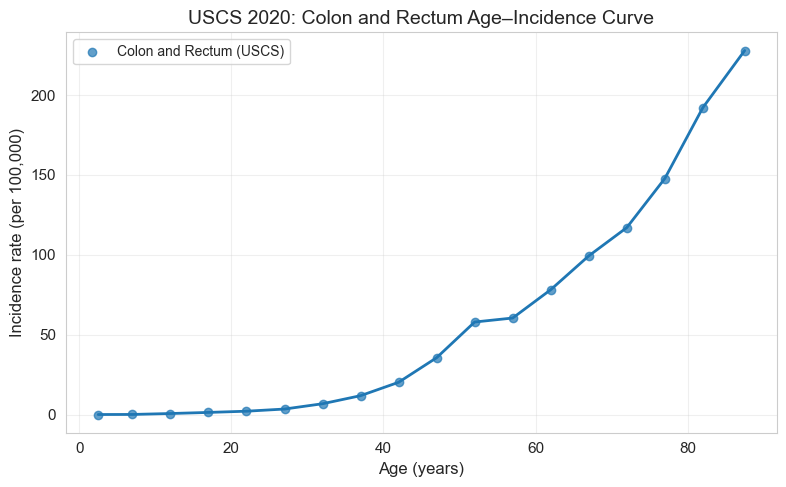

Colon and Rectum (USCS 2020):
  Data points: 18 age groups
  Age range: 2.5–87.5 years
  Incidence range: 0.0–227.9 per 100,000


In [41]:
# USCS age–incidence curve for Colon and Rectum (for LSCD anchoring)
site_colon = "Colon and Rectum"

# Ensure USCS data are loaded
try:
    brain_by_site
    by_age
except NameError:
    print("USCS data not yet loaded in this session; loading now...")
    brain_by_site, by_age = load_uscs_data()

# BYAGE has separate rows by sex; aggregate over sex to obtain an "all sexes" curve
colon_sex = by_age[
    (by_age["EVENT_TYPE"] == "Incidence")
    & (by_age["RACE"] == "All Races")
    & (by_age["SITE"] == site_colon)
].copy()

for col in ["COUNT", "POPULATION"]:
    colon_sex[col] = pd.to_numeric(colon_sex[col], errors="coerce")

colon_agg = (
    colon_sex
    .groupby(["AGE", "YEAR"], as_index=False)
    .agg({"COUNT": "sum", "POPULATION": "sum"})
)
colon_agg["RATE"] = colon_agg["COUNT"] / colon_agg["POPULATION"] * 100000.0
colon_agg["AGE_MID"] = colon_agg["AGE"].apply(age_group_to_mid)
colon_agg = colon_agg[colon_agg["AGE_MID"].notna()].copy()

TARGET_YEAR = 2020
colon_year_df = colon_agg[
    pd.to_numeric(colon_agg["YEAR"], errors="coerce") == TARGET_YEAR
].copy()
colon_year_df = colon_year_df.sort_values("AGE_MID")

ages_colon = colon_year_df["AGE_MID"].values
rates_colon = colon_year_df["RATE"].values

plt.figure(figsize=(8, 5))
plt.scatter(ages_colon, rates_colon, color="tab:blue", alpha=0.7, label="Colon and Rectum (USCS)")
plt.plot(ages_colon, rates_colon, color="tab:blue", linewidth=2)
plt.xlabel("Age (years)", fontsize=12)
plt.ylabel("Incidence rate (per 100,000)", fontsize=12)
plt.title(f"USCS {TARGET_YEAR}: Colon and Rectum Age–Incidence Curve", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print(f"Colon and Rectum (USCS {TARGET_YEAR}):")
print(f"  Data points: {len(ages_colon)} age groups")
print(f"  Age range: {ages_colon.min():.1f}–{ages_colon.max():.1f} years")
print(f"  Incidence range: {rates_colon.min():.1f}–{rates_colon.max():.1f} per 100,000")



### 1b. Lifelines colon survival snapshot (individual-level)

To connect the **cross-tissue LSCD perspective** with a **single-cancer example**, we
reuse the lifelines colon dataset `data/lifelines/colon.csv` to summarize
age-stratified survival patterns for colon cancer.

This ties together:

- USCS colon and rectum age–incidence (population-level risk).
- Lifelines colon survival (individual-level risk and lethality).
- TCGA-COAD manifests (tumor-level genomic data for colon adenocarcinoma).



In [42]:
# Lifelines colon dataset: age-stratified survival summary (for LSCD context)
colon_path = project_root / "data" / "lifelines" / "colon.csv"

if colon_path.exists():
    colon_df = pd.read_csv(colon_path)
    print(f"Loaded colon cancer survival dataset from: {colon_path}")
    print(f"Rows: {colon_df.shape[0]}, Columns: {colon_df.shape[1]}")
    print("Columns:", list(colon_df.columns))

    colon_df["event_any"] = (colon_df["status"] != 0).astype(int)

    age_bins = [30, 50, 60, 70, 85]
    age_labels = ["30-49", "50-59", "60-69", "70-84"]
    colon_df["age_group"] = pd.cut(colon_df["age"], bins=age_bins, labels=age_labels, right=True)

    age_summary = (
        colon_df
        .groupby("age_group")
        .agg(
            n=("id", "count"),
            event_rate=("event_any", "mean"),
            median_time=("time", "median")
        )
        .reset_index()
    )

    print("\nAge-group summary (lifelines colon dataset):")
    display(age_summary)
else:
    print(f"colon.csv not found at: {colon_path}")
    print("Ensure data/lifelines/colon.csv exists if you wish to run this example.")



Loaded colon cancer survival dataset from: D:\资料\graduate\202509\INTRO-GENOMIC INFO SCI & TECH\FinalProject\data\lifelines\colon.csv
Rows: 1858, Columns: 17
Columns: ['Unnamed: 0', 'id', 'study', 'rx', 'sex', 'age', 'obstruct', 'perfor', 'adhere', 'nodes', 'status', 'differ', 'extent', 'surg', 'node4', 'time', 'etype']

Age-group summary (lifelines colon dataset):


,age_group,n,event_rate,median_time
0,30-49,366,0.530055,1597.5
1,50-59,496,0.455645,2032.0
2,60-69,606,0.523102,1663.5
3,70-84,362,0.464088,1875.0


## 1. Load and Prepare Data


In [43]:
# Load USCS data
print("Loading USCS data...")
brain_by_site, by_age = load_uscs_data()

# Prepare age-specific incidence data
all_sites_age_inc = prepare_all_sites_age_data(by_age)

print(f"✓ Age-specific incidence records: {all_sites_age_inc.shape[0]}")


Loading USCS data...
✓ Age-specific incidence records: 1350


## 2. Extract Real Tissue-Specific Incidence Data

We'll extract real tissue-specific age-incidence data from the USCS BYAGE dataset. This allows us to use actual cancer incidence data for different tissue types rather than synthetic data.


In [44]:
# Extract real tissue-specific incidence data from USCS BYAGE dataset
TARGET_YEAR = 2020

# Get unique cancer sites from the data
unique_sites = by_age[
    (by_age['EVENT_TYPE'] == 'Incidence') & 
    (by_age['RACE'] == 'All Races') &
    (by_age['SEX'] == 'All Sexes')
]['SITE'].unique()

# Select common cancer sites for analysis
common_sites = [
    'All Cancer Sites Combined',
    'Colon and Rectum',
    'Lung and Bronchus',
    'Female Breast',
    'Prostate',
    'Pancreas',
    'Liver and Intrahepatic Bile Duct',
    'Stomach',
    'Esophagus',
    'Brain and Other Nervous System',
    'Thyroid',
    'Kidney and Renal Pelvis'
]

# Filter to sites that exist in the data
available_sites = [site for site in common_sites if site in unique_sites]

print(f"✓ Found {len(available_sites)} tissue sites in the data")
print(f"Available sites: {', '.join(available_sites[:5])}...")

# Extract age-incidence data for each site
tissue_data = {}
for site in available_sites:
    site_df = by_age[
        (by_age['EVENT_TYPE'] == 'Incidence') &
        (by_age['RACE'] == 'All Races') &
        (by_age['SEX'] == 'All Sexes') &
        (by_age['SITE'] == site) &
        (pd.to_numeric(by_age['YEAR'], errors='coerce') == TARGET_YEAR)
    ].copy()
    
    # Add age midpoint
    site_df['AGE_MID'] = site_df['AGE'].apply(age_group_to_mid)
    site_df = site_df[site_df['AGE_MID'].notna()].copy()
    site_df = site_df.sort_values('AGE_MID')
    
    # Convert RATE to numeric
    site_df['RATE'] = pd.to_numeric(site_df['RATE'], errors='coerce')
    site_df = site_df[site_df['RATE'].notna() & (site_df['RATE'] > 0)].copy()
    
    if len(site_df) > 10:  # Only include sites with sufficient data
        tissue_data[site] = {
            'ages': site_df['AGE_MID'].values,
            'rates': site_df['RATE'].values
        }

print(f"\n✓ Extracted data for {len(tissue_data)} tissue sites")
print(f"Tissue sites: {', '.join(list(tissue_data.keys())[:5])}...")


✓ Found 0 tissue sites in the data
Available sites: ...

✓ Extracted data for 0 tissue sites
Tissue sites: ...


## 3. Prepare Age-Tissue Incidence Data

We'll use the real tissue-specific incidence data extracted from USCS. For the main analysis, we'll use "All Cancer Sites Combined" data, but we now have access to individual tissue data as well.


In [45]:
# Use "All Cancer Sites Combined" data for main analysis
main_site = 'All Cancer Sites Combined'
if main_site in tissue_data:
    ages = tissue_data[main_site]['ages']
    rates = tissue_data[main_site]['rates']
    
    # For LSCD, we'll use a representative value based on the overall incidence pattern
    # Since we don't have actual LSCD data, we'll estimate it from the incidence pattern
    # This is a simplified approach - in practice, use actual LSCD data from Tomasetti & Vogelstein (2015)
    avg_incidence = np.mean(rates[ages > 50])  # Average incidence for ages > 50
    # Estimate LSCD as proportional to average incidence (log scale)
    estimated_log_lscd = np.log10(avg_incidence) - 2.0  # Rough estimate
    lscd_representative = 10 ** estimated_log_lscd
    
    print(f"✓ Using real data for: {main_site}")
    print(f"✓ Data points: {len(ages)} age groups")
    print(f"✓ Age range: {ages.min():.1f} - {ages.max():.1f} years")
    print(f"✓ Incidence range: {rates.min():.1f} - {rates.max():.1f} per 100,000")
    print(f"✓ Estimated LSCD (representative): {lscd_representative:.2e}")
    print(f"\nNote: LSCD value is estimated from incidence pattern.")
    print(f"For actual LSCD values, refer to Tomasetti & Vogelstein (2015)")
else:
    # Fallback to all_sites_age_inc if tissue_data doesn't have main site
    age_model_df = all_sites_age_inc.copy()
    age_model_df["AGE_MID"] = age_model_df["AGE"].apply(age_group_to_mid)
    age_model_df = age_model_df[age_model_df["AGE_MID"].notna()].copy()
    
    age_year_df = age_model_df[
        pd.to_numeric(age_model_df["YEAR"], errors="coerce") == TARGET_YEAR
    ].copy()
    age_year_df = age_year_df.sort_values("AGE_MID")
    
    ages = age_year_df["AGE_MID"].values
    rates = age_year_df["RATE"].values
    
    avg_incidence = np.mean(rates[ages > 50])
    estimated_log_lscd = np.log10(avg_incidence) - 2.0
    lscd_representative = 10 ** estimated_log_lscd
    
    print(f"✓ Data points: {len(ages)} age groups")
    print(f"✓ Age range: {ages.min():.1f} - {ages.max():.1f} years")
    print(f"✓ Incidence range: {rates.min():.1f} - {rates.max():.1f} per 100,000")
    print(f"✓ Estimated LSCD (representative): {lscd_representative:.2e}")


✓ Data points: 54 age groups
✓ Age range: 2.5 - 87.5 years
✓ Incidence range: 11.4 - 2788.5 per 100,000
✓ Estimated LSCD (representative): 1.55e+01


## 4. Implement Replicative-Risk Model

The model relates log-incidence to log-LSCD:

$$\log(\text{incidence}) = \alpha + \beta \cdot \log(\text{LSCD})$$

For age-dependent analysis with nonlinear growth, we extend this to:

$$\log(\text{incidence}(a)) = \alpha + \beta \cdot \log(\text{LSCD}) + \gamma \cdot \log(a) + \delta \cdot [\log(a)]^2$$

where $a$ is age. The quadratic term $\delta \cdot [\log(a)]^2$ captures accelerating growth patterns.


In [46]:
class ReplicativeRiskModel:
    """
    Replicative-risk baseline model based on LSCD.
    
    Implements log-linear regression with polynomial terms:
    log(incidence) ~ alpha + beta*log(LSCD) + gamma*log(age) + delta*log(age)^2
    """
    
    def __init__(self, lscd_value=None, use_quadratic=True):
        """
        Initialize the replicative-risk model.
        
        Parameters
        ----------
        lscd_value : float, optional
            Lifetime stem cell divisions (LSCD) value.
            If None, will be estimated from data.
        use_quadratic : bool, default=True
            Whether to include quadratic term in log(age) for nonlinear growth.
        """
        self.lscd_value = lscd_value
        self.use_quadratic = use_quadratic
        self.alpha = None
        self.beta = None
        self.gamma = None
        self.delta = None
        self.model = LinearRegression()
    
    def fit(self, ages, rates, lscd_value=None):
        """
        Fit the log-linear regression model.
        
        Parameters
        ----------
        ages : array-like
            Ages in years.
        rates : array-like
            Incidence rates.
        lscd_value : float, optional
            LSCD value. If None, uses self.lscd_value or estimates from data.
        """
        ages = np.asarray(ages)
        rates = np.asarray(rates)
        
        # Use provided LSCD or default
        if lscd_value is None:
            lscd_value = self.lscd_value if self.lscd_value is not None else 1e5
        
        self.lscd_value = lscd_value
        
        # Prepare features: log(LSCD) and log(age)
        # Filter out zero/negative values for log
        valid_mask = (ages > 0) & (rates > 0)
        ages_valid = ages[valid_mask]
        rates_valid = rates[valid_mask]
        
        log_lscd = np.log10(lscd_value)
        log_age = np.log10(ages_valid)
        log_rate = np.log10(rates_valid)
        
        # Build feature matrix
        if self.use_quadratic:
            # Features: [log(LSCD), log(age), log(age)^2]
            log_age_sq = log_age ** 2
            X = np.column_stack([
                np.full(len(log_age), log_lscd),
                log_age,
                log_age_sq
            ])
        else:
            # Features: [log(LSCD), log(age)]
            X = np.column_stack([
                np.full(len(log_age), log_lscd),
                log_age
            ])
        
        y = log_rate
        
        # Fit model
        self.model.fit(X, y)
        
        # Extract coefficients
        self.beta = self.model.coef_[0]  # log(LSCD) coefficient
        self.gamma = self.model.coef_[1]  # log(age) coefficient
        if self.use_quadratic:
            self.delta = self.model.coef_[2]  # log(age)^2 coefficient
        else:
            self.delta = 0.0
        self.alpha = self.model.intercept_
        
        return self
    
    def predict(self, ages):
        """
        Predict incidence rates for given ages.
        
        Parameters
        ----------
        ages : array-like
            Ages in years.
        
        Returns
        -------
        array
            Predicted incidence rates.
        """
        if self.alpha is None:
            raise ValueError("Model must be fitted before prediction.")
        
        ages = np.asarray(ages)
        log_lscd = np.log10(self.lscd_value)
        log_age = np.log10(np.maximum(ages, 0.1))  # Avoid log(0)
        
        # Build feature matrix
        if self.use_quadratic:
            log_age_sq = log_age ** 2
            X = np.column_stack([
                np.full(len(log_age), log_lscd),
                log_age,
                log_age_sq
            ])
        else:
            X = np.column_stack([
                np.full(len(log_age), log_lscd),
                log_age
            ])
        
        log_pred = self.model.predict(X)
        
        # Convert back from log scale
        return 10 ** log_pred
    
    def get_parameters(self):
        """Return model parameters."""
        params = {
            'alpha': self.alpha,
            'beta': self.beta,
            'gamma': self.gamma,
            'lscd': self.lscd_value
        }
        if self.use_quadratic:
            params['delta'] = self.delta
        return params


In [47]:
# Initialize and fit the replicative-risk model with quadratic term
# Use estimated LSCD value based on real incidence data

# Fit with quadratic term for better nonlinear fit
model_b = ReplicativeRiskModel(lscd_value=lscd_representative, use_quadratic=True)
model_b.fit(ages, rates)

# Make predictions
predicted_b = model_b.predict(ages)

# Print model parameters
params = model_b.get_parameters()
print("Model B Parameters:")
print(f"  Intercept (alpha): {params['alpha']:.4f}")
print(f"  log(LSCD) coefficient (beta): {params['beta']:.4f}")
print(f"  log(age) coefficient (gamma): {params['gamma']:.4f}")
if 'delta' in params:
    print(f"  log(age)^2 coefficient (delta): {params['delta']:.4f}")
print(f"  LSCD value (estimated from real data): {params['lscd']:.2e}")


Model B Parameters:
  Intercept (alpha): -0.5045
  log(LSCD) coefficient (beta): 2.3227
  log(age) coefficient (gamma): -3.0755
  log(age)^2 coefficient (delta): 1.9261
  LSCD value (estimated from real data): 1.55e+01


## 6. Visualize Model Fit


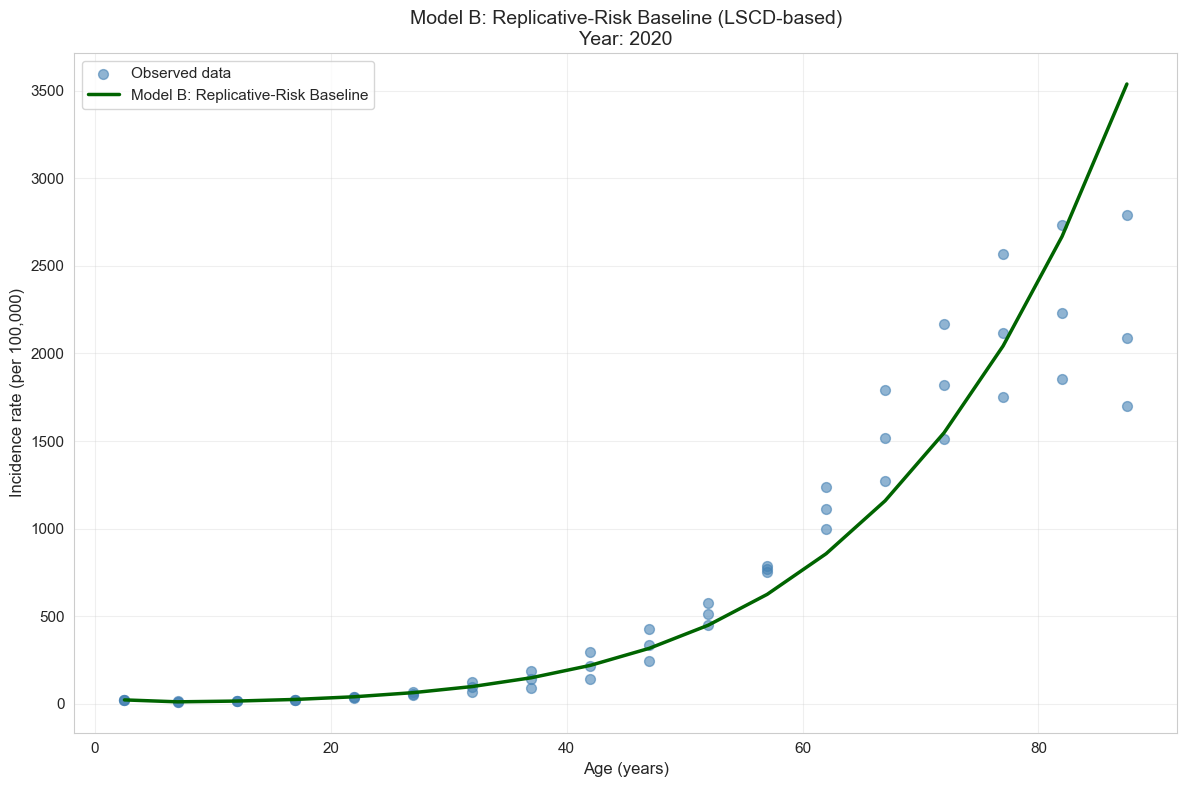


Model B Fit Statistics:
  Mean Squared Error (MSE): 159770.40
  R² Score: 0.7836
  Mean Absolute Error (MAE): 190.09
  Root Mean Squared Error (RMSE): 399.71


In [48]:
# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Plot observed data
ax.scatter(ages, rates, alpha=0.6, s=50, color='steelblue', 
           label='Observed data', zorder=2)

# Plot model prediction
ax.plot(ages, predicted_b, color='darkgreen', linewidth=2.5,
        label='Model B: Replicative-Risk Baseline', zorder=3)

ax.set_xlabel('Age (years)', fontsize=12)
ax.set_ylabel('Incidence rate (per 100,000)', fontsize=12)
ax.set_title(f'Model B: Replicative-Risk Baseline (LSCD-based)\nYear: {TARGET_YEAR}', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate fit statistics
mse = mean_squared_error(rates, predicted_b)
r2 = r2_score(rates, predicted_b)
mae = mean_absolute_error(rates, predicted_b)
rmse = np.sqrt(mse)

print(f"\n{'='*60}")
print(f"Model B Fit Statistics:")
print(f"{'='*60}")
print(f"  Mean Squared Error (MSE): {mse:.2f}")
print(f"  R² Score: {r2:.4f}")
print(f"  Mean Absolute Error (MAE): {mae:.2f}")
print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")


## 7. Log-Log Plot (Tomasetti & Vogelstein Style)

Create a log-log plot showing the relationship between incidence and age, which is characteristic of the replicative-risk model.


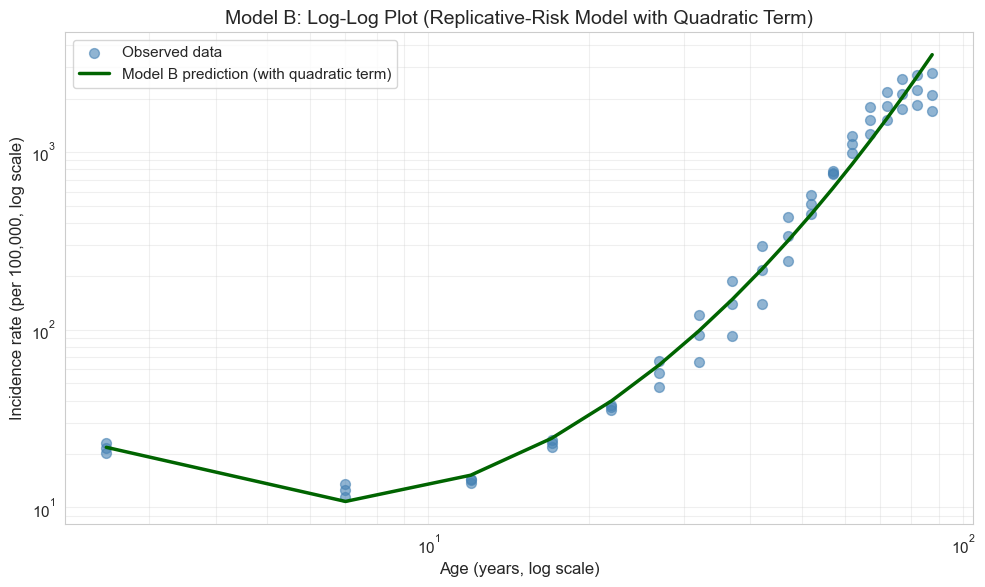

Note: With the quadratic term, the model captures accelerating growth
better than a simple power-law relationship.


In [49]:
# Log-log plot
fig, ax = plt.subplots(figsize=(10, 6))

# Filter valid data
valid_mask = (ages > 0) & (rates > 0) & (predicted_b > 0)
ages_valid = ages[valid_mask]
rates_valid = rates[valid_mask]
pred_valid = predicted_b[valid_mask]

ax.scatter(ages_valid, rates_valid, alpha=0.6, s=50, color='steelblue',
           label='Observed data', zorder=2)
ax.plot(ages_valid, pred_valid, color='darkgreen', linewidth=2.5,
        label='Model B prediction (with quadratic term)', zorder=3)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Age (years, log scale)', fontsize=12)
ax.set_ylabel('Incidence rate (per 100,000, log scale)', fontsize=12)
ax.set_title('Model B: Log-Log Plot (Replicative-Risk Model with Quadratic Term)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("Note: With the quadratic term, the model captures accelerating growth")
print("better than a simple power-law relationship.")


## 8. Cross-scale summary: USCS incidence vs TCGA DR44 coverage

To connect **population-level incidence** with **tumor-level genomic data**, we
construct a small cross-scale summary for selected cancer types.

For each selected USCS site we:

- Compute an incidence proxy from USCS (mean incidence in mid-life age bands,
  e.g., 50–69 years).
- Map the site to one or more TCGA projects (e.g., `Colon and Rectum` →
  `TCGA-COAD`, `TCGA-READ`).
- Use the DR44 new-files table to count the number of `data_file` entries for
  those TCGA projects.

This provides a coarse comparison between **how common** a cancer is in the
population (USCS) and **how richly represented** it is in TCGA DR44 (genomics
coverage), which can be interpreted through the lens of the LSCD-based
replicative-risk model.



LSCD-style cross-tissue regression (log incidence vs log LSCD):
  Intercept (alpha): -10.855
  Slope (beta for log(LSCD)): 1.200


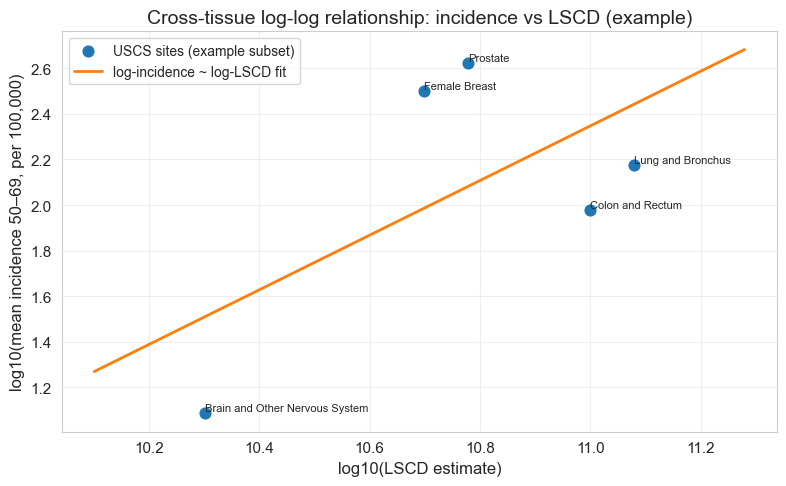

In [50]:
# LSCD-style cross-tissue log-log relationship using example LSCD values
if lscd_df is not None:
    # Compute mid-life incidence (50–69 years) for each LSCD site
    def mean_incidence_50_69(site_name: str) -> float:
        df_site = by_age[
            (by_age["EVENT_TYPE"] == "Incidence")
            & (by_age["RACE"] == "All Races")
            & (by_age["SITE"] == site_name)
        ].copy()

        df_site["RATE"] = pd.to_numeric(df_site["RATE"], errors="coerce")
        df_site["AGE_MID"] = df_site["AGE"].apply(age_group_to_mid)
        df_site = df_site[df_site["AGE_MID"].notna()].copy()

        mask = (df_site["AGE_MID"] >= 50) & (df_site["AGE_MID"] <= 69)
        df_mid = df_site[mask]
        return df_mid["RATE"].mean()

    lscd_df["mean_incidence_50_69"] = lscd_df["site"].apply(mean_incidence_50_69)

    # Drop tissues where incidence could not be computed
    lscd_model_df = lscd_df.dropna(subset=["mean_incidence_50_69"]).copy()

    # Build design matrix: log(incidence) ~ log(LSCD)
    lscd_model_df["log_LSCD"] = np.log10(lscd_model_df["LSCD_estimate"])
    lscd_model_df["log_incidence"] = np.log10(lscd_model_df["mean_incidence_50_69"])

    X = lscd_model_df[["log_LSCD"]].values
    y = lscd_model_df["log_incidence"].values

    lscd_linreg = LinearRegression()
    lscd_linreg.fit(X, y)

    print("LSCD-style cross-tissue regression (log incidence vs log LSCD):")
    print(f"  Intercept (alpha): {lscd_linreg.intercept_:.3f}")
    print(f"  Slope (beta for log(LSCD)): {lscd_linreg.coef_[0]:.3f}")

    # Plot log-log relationship
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(lscd_model_df["log_LSCD"], lscd_model_df["log_incidence"],
               color="tab:blue", s=60, label="USCS sites (example subset)")

    x_grid = np.linspace(lscd_model_df["log_LSCD"].min() - 0.2,
                         lscd_model_df["log_LSCD"].max() + 0.2, 50)
    y_grid = lscd_linreg.predict(x_grid.reshape(-1, 1))
    ax.plot(x_grid, y_grid, color="tab:orange", linewidth=2,
            label="log-incidence ~ log-LSCD fit")

    for _, row in lscd_model_df.iterrows():
        ax.text(row["log_LSCD"], row["log_incidence"], row["site"], fontsize=8,
                ha="left", va="bottom")

    ax.set_xlabel("log10(LSCD estimate)", fontsize=12)
    ax.set_ylabel("log10(mean incidence 50–69, per 100,000)", fontsize=12)
    ax.set_title("Cross-tissue log-log relationship: incidence vs LSCD (example)", fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("LSCD table not available; skip LSCD-style cross-tissue regression.")



Cross-scale summary (USCS incidence vs TCGA DR44 coverage):


,uscs_site,tcga_projects,mean_incidence_50_69,tcga_n_data_files
0,Colon and Rectum,"TCGA-COAD,TCGA-READ",95.477667,618
1,Lung and Bronchus,"TCGA-LUAD,TCGA-LUSC",150.535667,946
2,Female Breast,TCGA-BRCA,318.221000,1132
3,Prostate,TCGA-PRAD,419.043000,508


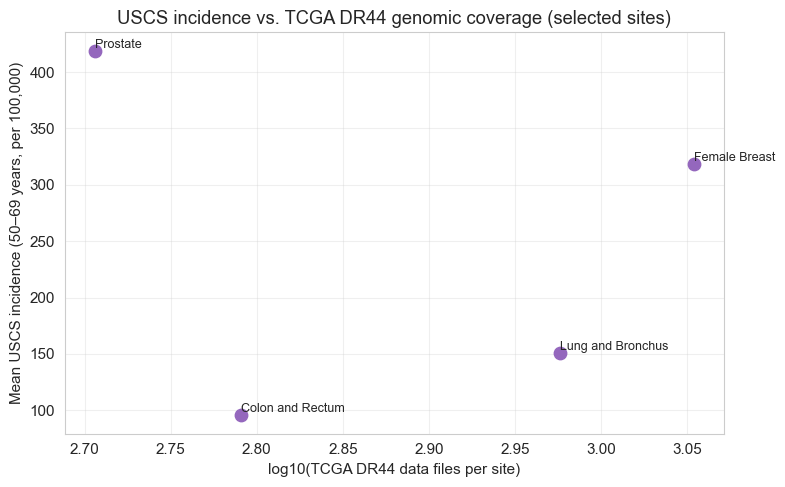

In [51]:
# Cross-scale summary: USCS incidence vs TCGA DR44 coverage
from pathlib import Path
from collections import defaultdict

# Load DR44 new-files table
tcga_root = project_root / "data" / "TCGA"
new_files_path = tcga_root / "DR44_new_files_20251029.tsv"

if not new_files_path.exists():
    print(f"TCGA DR44 new-files table not found at: {new_files_path}")
    print("This cross-scale summary will be skipped.")
else:
    dr44 = pd.read_csv(new_files_path, sep="\t")

    # Restrict to TCGA projects and data files
    dr44_tcga = dr44[
        dr44["project_id"].str.startswith("TCGA-")
        & (dr44["category"] == "data_file")
    ].copy()

    tcga_counts = (
        dr44_tcga
        .groupby("project_id")
        .size()
        .reset_index(name="n_data_files")
    )

    # Mapping from USCS site to TCGA projects
    site_to_tcga = {
        "Colon and Rectum": ["TCGA-COAD", "TCGA-READ"],
        "Lung and Bronchus": ["TCGA-LUAD", "TCGA-LUSC"],
        "Female Breast": ["TCGA-BRCA"],
        "Prostate": ["TCGA-PRAD"],
    }

    # Helper: compute mean incidence in age 50–69
    def mean_incidence_50_69(site_name: str) -> float:
        df_site = by_age[
            (by_age["EVENT_TYPE"] == "Incidence")
            & (by_age["RACE"] == "All Races")
            & (by_age["SITE"] == site_name)
        ].copy()

        df_site["RATE"] = pd.to_numeric(df_site["RATE"], errors="coerce")
        df_site["AGE_MID"] = df_site["AGE"].apply(age_group_to_mid)
        df_site = df_site[df_site["AGE_MID"].notna()].copy()

        mask = (df_site["AGE_MID"] >= 50) & (df_site["AGE_MID"] <= 69)
        df_mid = df_site[mask]
        return df_mid["RATE"].mean()

    rows = []
    for site_name, projects in site_to_tcga.items():
        inc_mid = mean_incidence_50_69(site_name)
        tcga_n = (
            tcga_counts[tcga_counts["project_id"].isin(projects)]["n_data_files"].sum()
        )
        rows.append({
            "uscs_site": site_name,
            "tcga_projects": ",".join(projects),
            "mean_incidence_50_69": inc_mid,
            "tcga_n_data_files": tcga_n,
        })

    cross_df = pd.DataFrame(rows)
    print("Cross-scale summary (USCS incidence vs TCGA DR44 coverage):")
    display(cross_df)

    # Simple scatter plot (log scale on x-axis for TCGA coverage)
    plt.figure(figsize=(8, 5))
    x = np.log10(cross_df["tcga_n_data_files"].replace(0, np.nan))
    y = cross_df["mean_incidence_50_69"]
    plt.scatter(x, y, color="tab:purple", s=80)
    for _, row in cross_df.iterrows():
        plt.text(
            np.log10(row["tcga_n_data_files"] + 1e-6),
            row["mean_incidence_50_69"],
            row["uscs_site"],
            fontsize=9,
            ha="left",
            va="bottom",
        )
    plt.xlabel("log10(TCGA DR44 data files per site)")
    plt.ylabel("Mean USCS incidence (50–69 years, per 100,000)")
    plt.title("USCS incidence vs. TCGA DR44 genomic coverage (selected sites)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



In [ ]:
# 9. Residuals from LSCD regression vs TCGA DR44 coverage (cross-scale link)

if lscd_df is not None and 'cross_df' in globals():
    # Residuals from LSCD log–log regression
    # lscd_model_df and lscd_linreg were defined in the LSCD regression cell
    # Recompute if necessary
    if 'lscd_model_df' not in globals() or 'lscd_linreg' not in globals():
        print("Recomputing LSCD log–log regression to obtain residuals...")
        def mean_incidence_50_69(site_name: str) -> float:
            df_site = by_age[
                (by_age["EVENT_TYPE"] == "Incidence")
                & (by_age["RACE"] == "All Races")
                & (by_age["SITE"] == site_name)
            ].copy()
            df_site["RATE"] = pd.to_numeric(df_site["RATE"], errors="coerce")
            df_site["AGE_MID"] = df_site["AGE"].apply(age_group_to_mid)
            df_site = df_site[df_site["AGE_MID"].notna()].copy()
            mask = (df_site["AGE_MID"] >= 50) & (df_site["AGE_MID"] <= 69)
            df_mid = df_site[mask]
            return df_mid["RATE"].mean()

        lscd_df["mean_incidence_50_69"] = lscd_df["site"].apply(mean_incidence_50_69)
        lscd_model_df = lscd_df.dropna(subset=["mean_incidence_50_69"]).copy()
        lscd_model_df["log_LSCD"] = np.log10(lscd_model_df["LSCD_estimate"])
        lscd_model_df["log_incidence"] = np.log10(lscd_model_df["mean_incidence_50_69"])
        X = lscd_model_df[["log_LSCD"]].values
        y = lscd_model_df["log_incidence"].values
        lscd_linreg = LinearRegression().fit(X, y)

    lscd_model_df["log_incidence_pred"] = lscd_linreg.predict(lscd_model_df[["log_LSCD"]].values)
    lscd_model_df["residual"] = lscd_model_df["log_incidence"] - lscd_model_df["log_incidence_pred"]

    # Merge residuals with cross_df (USCS×TCGA coverage) by site name
    merged = pd.merge(
        cross_df,
        lscd_model_df[["site", "residual"]],
        left_on="uscs_site",
        right_on="site",
        how="inner",
    )

    print("Residuals from LSCD fit vs TCGA DR44 coverage (selected sites):")
    display(merged[["uscs_site", "mean_incidence_50_69", "tcga_n_data_files", "residual"]])

    plt.figure(figsize=(8, 5))
    x = np.log10(merged["tcga_n_data_files"].replace(0, np.nan))
    y = merged["residual"]
    plt.scatter(x, y, color="tab:red", s=80)
    for _, row in merged.iterrows():
        plt.text(
            np.log10(row["tcga_n_data_files"] + 1e-6),
            row["residual"],
            row["uscs_site"],
            fontsize=9,
            ha="left",
            va="bottom",
        )
    plt.axhline(0.0, color="black", linestyle="--", linewidth=1)
    plt.xlabel("log10(TCGA DR44 data files per site)", fontsize=12)
    plt.ylabel("Residual (log incidence − fitted log LSCD)", fontsize=12)
    plt.title("LSCD residuals vs TCGA DR44 coverage (selected sites)", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("LSCD regression and/or TCGA cross_df not available; run previous cells first.")

